In [2]:
from pathlib import Path
drive_dir = Path("../")

import sys
import os
module_path = os.path.abspath(str(drive_dir))
sys.path.insert(0, module_path)

data_dir = Path(drive_dir, "data-test/")
results_dir = Path(data_dir, "results/predict-286-gutenberg")


import katspace as ks
import katspace.core

from katspace.data import results_from_json


import importlib
importlib.reload(sys.modules["katspace.data"])

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from itertools import chain 

from sklearn import linear_model
import statsmodels.api as sm
import ujson

import functools
from functools import reduce

import operator


In [3]:
label2id = {"perceived_space": 0, "action_space": 1, "visual_space": 2, "descriptive_space":3, "no_space":4}
id2label = dict(map(reversed, label2id.items()))
space_types = label2id.keys()
id_matrix = np.eye(len(label2id), dtype = np.integer)

# Single text

In [ ]:
results_prozess = results_from_json("Franz_Kafka_-_Der_Prozeß.txt", results_dir)
results_verwandlung = results_from_json("Franz_Kafka_-_Die_Verwandlung.txt", results_dir)

In [ ]:
label2id = {"perceived_space": 0, "action_space": 1, "visual_space": 2, "descriptive_space":3, "no_space":4}
id2label = dict(map(reversed, label2id.items()))
space_types = label2id.keys()

space_type_ids = [label2id[result["label"]] for result in results_prozess]
print(space_type_ids)
print(results_prozess)

In [ ]:
results_a = id_matrix[space_type_ids]
len(results_a)

In [ ]:
#bin_size = 100
action_space = [result[1] for result in results_a] 
action_space_results = list(map(sum, ks.data.chunker(action_space, num_chunks = num_chunks)))
action_space_results

In [ ]:
plt.plot(range(len(action_space_results)), action_space_results)
print(len(action_space_results))

In [ ]:
nr_sents = len(action_space)
bin_sizes = ks.data.chunk_lengths(nr_sents, num_chunks = num_chunks)
sent_count = [sum(bin_sizes[0:n]) for n in range(len(bin_sizes))]

df = pd.DataFrame({"sent_count" : sent_count,     
    "action_space" : action_space_results,
    "bin_size" : bin_sizes
    })

#df["action_space_tf"] = df["action_space"] - df.action_space.mean()

df["time_tf"] = np.pi * (df["sent_count"] / df.sent_count.max())

df["sin"] = np.sin(df.time_tf)
df["cos"] = np.cos(df.time_tf)

df["sin2"] = np.sin(2*df.time_tf)
df["cos2"] = np.cos(2*df.time_tf)

df

# All texts

In [ ]:
#old

notebooks_dir =  Path(drive_dir, "Colab Notebooks/katspace-project/notebooks/")
gutenberg_df = pd.read_excel(Path(notebooks_dir, "20231216_1_gutenberg_master.xlsx"), index_col = 0)

file_list = gutenberg_df.filename
results_dic = {filename : results_from_json(filename, results_dir) for filename in file_list}

num_chunks = 20
results_dic = {filename : res for filename, res in results_dic.items() if (res != None) and (len(res) >= num_chunks)}

file_list = results_dic.keys()

space_type_ids_dict = {filename : [label2id[result["label"]] for result in results_dic[filename]] for filename in file_list}
print(space_type_ids_dict["Franz_Kafka_-_Der_Prozeß.txt"])
#print(results_prozess)

print(space_type_ids_dict["Franz_Kafka_-_Die_Verwandlung.txt"])
#print(results_verwandlung)

In [4]:
def load_all_results_f_json(): 

    label2id = {"perceived_space": 0, "action_space": 1, "visual_space": 2, "descriptive_space":3, "no_space":4}
    id_matrix = np.eye(len(label2id), dtype = np.integer)
    
    #notebooks_dir =  Path(drive_dir, "Colab Notebooks/katspace-project/notebooks/")
    gutenberg_df = pd.read_excel(Path(data_dir, "20231216_1_gutenberg_master.xlsx"), index_col = 0)
    #gutenberg_df = pd.read_excel(Path(data_dir, "20240818_canon_master_merged.xlsx", index = 0))

    file_list = gutenberg_df.filename
    results_dic = {filename : results_from_json(filename, results_dir) for filename in file_list}

    num_chunks = 20
    results_dic = {filename : res for filename, res in results_dic.items() if (res != None) and (len(res) >= num_chunks)}

    file_list = results_dic.keys()

    space_type_ids_dict = {filename : [label2id[result["label"]] for result in results_dic[filename]] for filename in file_list}
    results_a_dict = {filename : id_matrix[space_type_ids_dict[filename]] for filename in file_list}

    return results_a_dict, file_list, gutenberg_df
    

In [5]:
results_a_dict, file_list, gutenberg_df = load_all_results_f_json()

In [6]:
def chunk_data(results_a_dict, num_chunks = 20): 
    chunk_length_dict = {filename : ks.data.chunk_lengths(len(results_a_dict[filename]), num_chunks) for filename in file_list}
    results_chunked_dict = {filename : list(map(sum, ks.data.chunker(results_a_dict[filename], num_chunks = num_chunks))) for filename in file_list}
    return chunk_length_dict, results_chunked_dict

In [7]:
num_chunks = 20
chunk_length_dict, results_chunked_dict = chunk_data(results_a_dict) 

In [8]:
data_dict = {
    (filename, space_type) :
                            [result[label2id[space_type]] for result in results_chunked_dict[filename]]
                              for (filename, space_type) in itertools.product(file_list, space_types)
                              } | {
                                  (filename, "all_space") : [total - result[label2id["no_space"]] for result, total in 
                                                             zip(results_chunked_dict[filename], chunk_length_dict[filename])]
                                                            for filename in file_list
                              } | {
                                  (filename, "total") : chunk_length_dict[filename] for filename in file_list
                                  } 

for filename in file_list:
    bin_sizes = data_dict[(filename, "total")]
    sent_count = [sum(bin_sizes[0:n + 1]) for n in range(len(bin_sizes))]
    data_dict[(filename, "sent_count")] = sent_count

index = pd.MultiIndex.from_product([file_list, list(katspace.core.space_types_ext) + ["total", "sent_count"]])
results_df = pd.DataFrame(data_dict, columns = index)

#results_df.reindex(columns = itertools.product([file_list, space_types]),  axis = 1)
results_df

Abraham_a_Sancta_Clara_-_Wunderlicher_Traum_von_einem_großen_Narrennest.txt  \
                                                               perceived_space   
0                                                   1                            
1                                                   0                            
2                                                   0                            
3                                                   0                            
4                                                   0                            
5                                                   2                            
6                                                   0                            
7                                                   1                            
8                                                   1                            
9                                                   5                            
10                                                  0                            
11                                                  0                            
12                                                  0                            
13                                                  1                            
14                                                  0                            
15                                                  0                            
16                                                  0                            
17                                                  2                            
18                                                  0                            
19                                                  0                            

                                                                         \
   action_space visual_space descriptive_space no_space all_space total   
0             1            0                 0       26         2    28   
1             2            0                 0       26         2    28   
2             1            0                 1       26         2    28   
3             2            0                 0       26         2    28   
4             4            0                 1       23         5    28   
5             0            0                 1       25         3    28   
6             1            0                 0       27         1    28   
7             1            0                 0       26         2    28   
8             2            0                 2       23         5    28   
9             4            0                 0       19         9    28   
10            1            0                 0       27         1    28   
11            6            0                 0       22         6    28   
12            1            0                 0       27         1    28   
13            5            0                 0       22         6    28   
14            0            0                 0       28         0    28   
15            1            0                 0       27         1    28   
16            1            0                 0       27         1    28   
17            0            0                 1       25         3    28   
18            3            0                 0       25         3    28   
19            2            0                 0       25         2    27   

              Abraham_a_Sancta_Clara_-_Fabeln_und_Parabeln.txt               \
   sent_count                                  perceived_space action_space   
0          28                                                2            3   
1          56                                                1            7   
2          84                                                0            6   
3         112                                                5            3   
4         140                                                2           

In [9]:
temp_dict = {}
for filename, space_type in results_df.columns: 
    col = space_type + "_n"   
    temp_dict[(filename, col)] = results_df.loc[:,(filename, space_type)] / results_df.loc[:,(filename, "total")]


normed_df = pd.DataFrame(temp_dict)
#normed_df.index = pd.MultiIndex.from_frame(time_df)
normed_df.sort_index(axis = "columns", inplace = True)
normed_df



A._Apel_und_F._Laun_-_Gespensterbuch._Drittes_Bändchen.txt              \
                                               action_space_n all_space_n   
0                                            0.121212            0.227273   
1                                            0.159091            0.325758   
2                                            0.181818            0.318182   
3                                            0.068182            0.121212   
4                                            0.143939            0.181818   
5                                            0.136364            0.250000   
6                                            0.128788            0.303030   
7                                            0.037879            0.121212   
8                                            0.121212            0.189394   
9                                            0.166667            0.333333   
10                                           0.106061            0.310606   
11                                           0.068182            0.106061   
12                                           0.030303            0.037879   
13                                           0.143939            0.257576   
14                                           0.213740            0.251908   
15                                           0.167939            0.297710   
16                                           0.160305            0.396947   
17                                           0.137405            0.312977   
18                                           0.137405            0.267176   
19                                           0.213740            0.419847   

                                                                          \
   descriptive_space_n no_space_n perceived_space_n sent_count_n total_n   
0             0.015152   0.772727          0.083333      1.00000     1.0   
1             0.030303   0.674242          0.121212      2.00000     1.0   
2             0.015152   0.681818          0.113636      3.00000     1.0   
3             0.015152   0.878788          0.037879      4.00000     1.0   
4             0.000000   0.818182          0.037879      5.00000     1.0   
5             0.000000   0.750000          0.106061      6.00000     1.0   
6             0.037879   0.696970          0.136364      7.00000     1.0   
7             0.000000   0.878788          0.083333      8.00000     1.0   
8             0.000000   0.810606          0.053030      9.00000     1.0   
9             0.053030   0.666667          0.106061     10.00000     1.0   
10            0.053030   0.689394          0.113636     11.00000     1.0   
11            0.007576   0.893939          0.030303     12.00000     1.0   
12            0.000000   0.962121          0.007576     13.00000     1.0   
13            0.007576   0.742424          0.083333     14.00000     1.0   
14            0.000000   0.748092          0.030534     15.10687     1.0   
15            0.038168   0.702290          0.091603     16.10687     1.0   
16            0.038168   0.603053          0.190840     17.10687     1.0   
17            0.030534   0.687023          0.129771     18.10687     1.0   
18            0.000000   0.732824          0.122137     19.10687     1.0   
19            0.015267   0.580153          0.167939     20.10687     1.0   

                  A._Apel_und_F._Laun_-_Gespensterbuch._Fünftes_Bändchen.txt  \
   visual_space_n                                             action_space_n   
0        0.007576                                           0.084746           
1        0.015152                                           0.101695           
2        0.007576                                           0.152542           
3        0.000000                                           0.203390           
4        0.000000                                           0.127119           
5        0.007576                                           0.101695       

In [10]:
def mk_time_df(df, exact = False, filename = None):
    time_df = pd.DataFrame()
    if not exact: 
        time_tf = np.pi * (df.index / df.index.max())
        time_df["time_tf"] = time_tf 
    elif exact: 
        time_tf = df[(filename, "time_tf_n")]
        time_df["time_tf"] = time_tf

    time_df["sin"] = np.sin(time_tf)
    time_df["cos"] = np.cos(time_tf)

    time_df["sin2"] = np.sin(2*time_tf)
    time_df["cos2"] = np.cos(2*time_tf)
    return time_df

In [11]:
time_df = mk_time_df(results_df)

def fit(normed_df, space_type, time_df = time_df): 
    x = pd.DataFrame()
    y = pd.Series()

    for filename in normed_df.columns.get_level_values(0).unique():
        x = pd.concat([x, time_df[['time_tf', "sin", "cos", "sin2", "cos2"]]], axis = 0)
        y = pd.concat([y, normed_df[(filename, space_type)]], axis = 0)
    
    # with statsmodels
    xx = sm.add_constant(x) # adding a constant
    time_tf = np.pi * np.arange(1,len(normed_df.index) + 1) / len(normed_df.index)
    time_tf = sm.add_constant(time_tf)
    
    model = sm.OLS(y, xx).fit()
    
    print_model = model.summary()
    print(print_model)
    return x, y, model

def predict(model, time_df = time_df): 
    time_df = sm.add_constant(time_df) # adding a constant
    predictions = model.predict(time_df) 
    return time_df["time_tf"], predictions

In [12]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_theme()

/var/folders/yd/lp8syplj03d658531gh7ckfc0000gp/T/ipykernel_32832/3348595996.py:9: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y = pd.concat([y, normed_df[(filename, space_type)]], axis = 0)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     9.261
Date:                Wed, 19 Feb 2025   Prob (F-statistic):           7.92e-09
Time:                        11:15:15   Log-Likelihood:                 50887.
No. Observations:               95420   AIC:                        -1.018e+05
Df Residuals:                   95414   BIC:                        -1.017e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3571      0.038      9.281      0.0

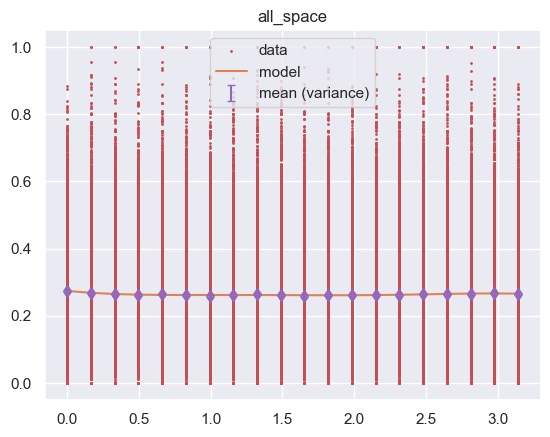

In [13]:
x, y, model = fit(normed_df, "all_space_n")

x_pred, predictions = predict(model, time_df)

err = normed_df.loc[:,(slice(None), "all_space_n")].var(axis = 1)
mean = normed_df.loc[:,(slice(None), "all_space_n")].mean(axis = 1)

plt.scatter(x["time_tf"], y, label = "data", s = 1, color = "#c44e52")
plt.plot(x_pred, predictions, label = "model", color = "#dd8452")
plt.errorbar(x["time_tf"][0:20], mean, yerr=err, uplims= True, lolims= True, linestyle='none', label = "mean (variance)", color = "#9467bd")
plt.legend()
_ = plt.title("all_space")

/var/folders/yd/lp8syplj03d658531gh7ckfc0000gp/T/ipykernel_32832/3348595996.py:9: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y = pd.concat([y, normed_df[(filename, space_type)]], axis = 0)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     40.97
Date:                Wed, 19 Feb 2025   Prob (F-statistic):           2.87e-42
Time:                        11:15:50   Log-Likelihood:             1.0171e+05
No. Observations:               95420   AIC:                        -2.034e+05
Df Residuals:                   95414   BIC:                        -2.033e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2062      0.023      9.127      0.0

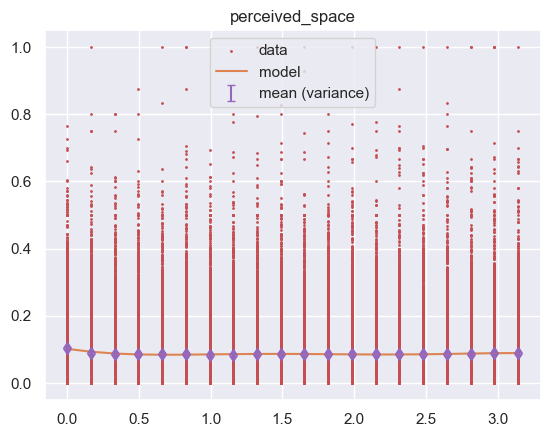

In [14]:
x, y, model = fit(normed_df, "perceived_space_n")

x_pred, predictions = predict(model, time_df)

err = normed_df.loc[:,(slice(None), "perceived_space_n")].var(axis = 1)
mean = normed_df.loc[:,(slice(None), "perceived_space_n")].mean(axis = 1)

plt.scatter(x["time_tf"], y, label = "data", s = 1, color = "#c44e52")
plt.plot(x_pred, predictions, label = "model", color = "#dd8452")
plt.errorbar(x["time_tf"][0:20], mean, yerr=err, uplims= True, lolims= True, linestyle='none', label = "mean (variance)", color = "#9467bd")
plt.legend()
_ = plt.title("perceived_space")

/var/folders/yd/lp8syplj03d658531gh7ckfc0000gp/T/ipykernel_32832/3348595996.py:9: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y = pd.concat([y, normed_df[(filename, space_type)]], axis = 0)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     228.2
Date:                Wed, 19 Feb 2025   Prob (F-statistic):          4.95e-243
Time:                        11:16:11   Log-Likelihood:             2.0504e+05
No. Observations:               95420   AIC:                        -4.101e+05
Df Residuals:                   95414   BIC:                        -4.100e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0928      0.008     12.134      0.0

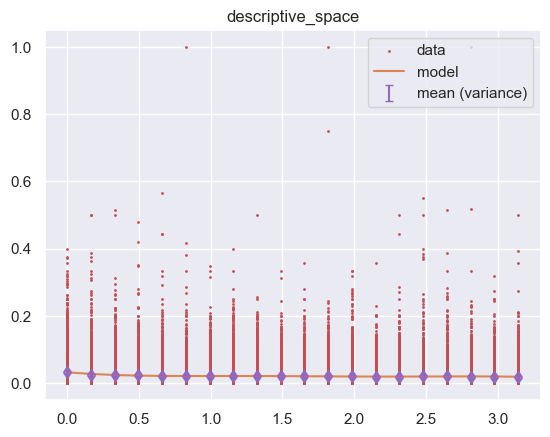

In [15]:
x, y, model = fit(normed_df, "descriptive_space_n")

x_pred, predictions = predict(model, time_df)

err = normed_df.loc[:,(slice(None), "descriptive_space_n")].var(axis = 1)
mean = normed_df.loc[:,(slice(None), "descriptive_space_n")].mean(axis = 1)

plt.scatter(x["time_tf"], y, label = "data", s = 1, color = "#c44e52")
plt.plot(x_pred, predictions, label = "model", color = "#dd8452")
plt.errorbar(x["time_tf"][0:20], mean, yerr=err, uplims= True, lolims= True, linestyle='none', label = "mean (variance)", color = "#9467bd")
plt.legend()
_ = plt.title("descriptive_space")

/var/folders/yd/lp8syplj03d658531gh7ckfc0000gp/T/ipykernel_40863/2254291661.py:9: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y = pd.concat([y, normed_df[(filename, space_type)]], axis = 0)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     53.10
Date:                Sat, 02 Nov 2024   Prob (F-statistic):           3.13e-55
Time:                        09:02:02   Log-Likelihood:                 96842.
No. Observations:               95420   AIC:                        -1.937e+05
Df Residuals:                   95414   BIC:                        -1.936e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0392      0.024      1.647      0.1

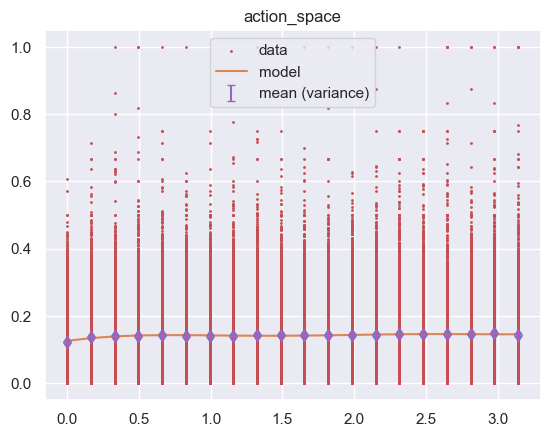

In [54]:
x, y, model = fit(normed_df, "action_space_n")

x_pred, predictions = predict(model, time_df)

err = normed_df.loc[:,(slice(None), "action_space_n")].var(axis = 1)
mean = normed_df.loc[:,(slice(None), "action_space_n")].mean(axis = 1)

plt.scatter(x["time_tf"], y, label = "data", s = 1, color = "#c44e52")
plt.plot(x_pred, predictions, label = "model", color = "#dd8452")
plt.errorbar(x["time_tf"][0:20], mean, yerr=err, uplims= True, lolims= True, linestyle='none', label = "mean (variance)", color = "#9467bd")
plt.legend()
_ = plt.title("action_space")

/var/folders/yd/lp8syplj03d658531gh7ckfc0000gp/T/ipykernel_40863/2254291661.py:9: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y = pd.concat([y, normed_df[(filename, space_type)]], axis = 0)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     14.48
Date:                Sat, 02 Nov 2024   Prob (F-statistic):           3.27e-14
Time:                        09:02:26   Log-Likelihood:             2.4793e+05
No. Observations:               95420   AIC:                        -4.958e+05
Df Residuals:                   95414   BIC:                        -4.958e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.005      3.890      0.0

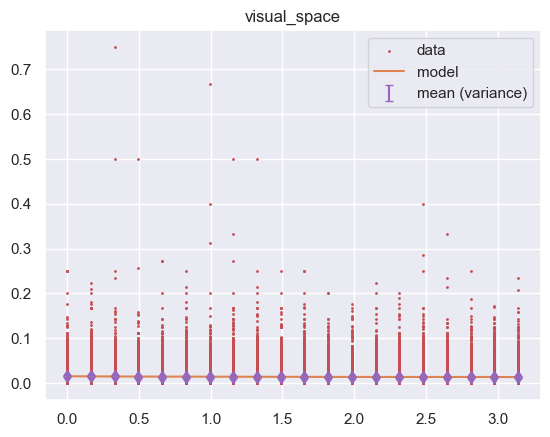

In [55]:
x, y, model = fit(normed_df, "visual_space_n")

x_pred, predictions = predict(model, time_df)

err = normed_df.loc[:,(slice(None), "visual_space_n")].var(axis = 1)
mean = normed_df.loc[:,(slice(None), "visual_space_n")].mean(axis = 1)

plt.scatter(x["time_tf"], y, label = "data", s = 1, color = "#c44e52")
plt.plot(x_pred, predictions, label = "model", color = "#dd8452")
plt.errorbar(x["time_tf"][0:20], mean, yerr=err, uplims= True, lolims= True, linestyle='none', label = "mean (variance)", color = "#9467bd")
plt.legend()
_ = plt.title("visual_space")

In [11]:
def query(sel_obj):
    if isinstance(sel_obj, ks.sel.Crit): 
        return sel_obj.test(sel_obj.value)
    elif isinstance(sel_obj, ks.sel.Not): 
        return ~ query(sel_obj.selection)
    elif isinstance(sel_obj, ks.sel.MatchAll): 
        return pd.Series(4783 * [True])
    elif isinstance(sel_obj, ks.sel.And):
        return reduce(operator.and_, map(query, sel_obj.selections))


def selection(normed_df, text_sel): 
    sel = None
    bool_sel = query(text_sel)
    fn_sel_raw = set(gutenberg_df[bool_sel]["filename"])
    file_list = normed_df.columns.get_level_values(0)
    sel = [filename for filename in fn_sel_raw if filename in set(file_list)]
    normed_df_sel = normed_df.loc[:, (sel,slice(None))]
    return normed_df_sel

In [12]:
gutenberg_df["genre_3"].unique()

array(['Humor, Satire', 'Märchen, Sagen, Legenden',
       'Romane, Novellen und Erzählungen',
       'Historische Romane und Erzählungen', 'Krimis, Thriller, Spionage',
       'Historische Kriminalromane und -fälle', 'Horror',
       'Phantastische Literatur', 'Spannung und Abenteuer',
       'Romanhafte Biographien', 'Science Fiction', 'Jugendliteratur'],
      dtype=object)

In [13]:
text_sel = ks.sel.Crit(test = gutenberg_df.loc[:, "genre_3"].str.contains, value = "Krimis")
normed_df_sel = selection(normed_df, text_sel)

In [24]:
err = normed_df_sel.loc[:,(slice(None), "action_space_n")].var(axis = 1)
mean = normed_df_sel.loc[:,(slice(None), "action_space_n")].mean(axis = 1)

/var/folders/yd/lp8syplj03d658531gh7ckfc0000gp/T/ipykernel_52934/3348595996.py:9: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y = pd.concat([y, normed_df[(filename, space_type)]], axis = 0)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     22.00
Date:                Wed, 22 Jan 2025   Prob (F-statistic):           8.38e-22
Time:                        16:31:44   Log-Likelihood:                 8992.5
No. Observations:                3940   AIC:                        -1.797e+04
Df Residuals:                    3934   BIC:                        -1.794e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1119      0.033      3.395      0.0

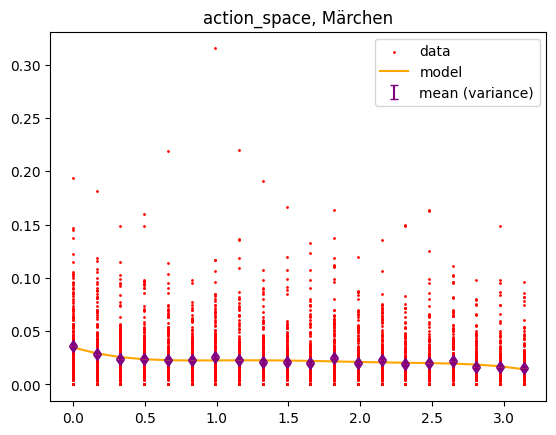

In [81]:
x, y, model = fit(normed_df_sel, "descriptive_space_n")

x_pred, predictions = predict(model, time_df)

err = normed_df_sel.loc[:,(slice(None), "descriptive_space_n")].var(axis = 1)
mean = normed_df_sel.loc[:,(slice(None), "descriptive_space_n")].mean(axis = 1)

plt.scatter(x["time_tf"], y, label = "data", s = 1, color = "red")
plt.plot(x_pred, predictions, label = "model", color = "orange")
plt.errorbar(x["time_tf"][0:20], mean, yerr=err, uplims= True, lolims= True, linestyle='none', label = "mean (variance)", color = "purple")
plt.legend()
_ = plt.title("action_space, Märchen")

/var/folders/yd/lp8syplj03d658531gh7ckfc0000gp/T/ipykernel_52934/3348595996.py:9: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y = pd.concat([y, normed_df[(filename, space_type)]], axis = 0)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     9.450
Date:                Tue, 21 Jan 2025   Prob (F-statistic):           5.71e-09
Time:                        17:45:28   Log-Likelihood:                 6440.8
No. Observations:                3940   AIC:                        -1.287e+04
Df Residuals:                    3934   BIC:                        -1.283e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1910      0.063      3.032      0.0

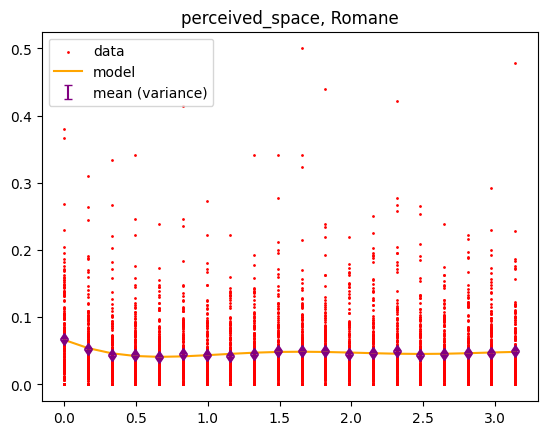

In [26]:
x, y, model = fit(normed_df_sel, "perceived_space_n")

x_pred, predictions = predict(model, time_df)

err = normed_df_sel.loc[:,(slice(None), "perceived_space_n")].var(axis = 1)
mean = normed_df_sel.loc[:,(slice(None), "perceived_space_n")].mean(axis = 1)

plt.scatter(x["time_tf"], y, label = "data", s = 1, color = "red")
plt.plot(x_pred, predictions, label = "model", color = "orange")
plt.errorbar(x["time_tf"][0:20], mean, yerr=err, uplims= True, lolims= True, linestyle='none', label = "mean (variance)", color = "purple")
plt.legend()
_ = plt.title("perceived_space, Romane")

In [ ]:
x, y, model = fit(normed_df_sel, "action_space_n")

x_pred, predictions = predict(model, time_df)

err = normed_df_sel.loc[:,(slice(None), "action_space_n")].var(axis = 1)
mean = normed_df_sel.loc[:,(slice(None), "action_space_n")].mean(axis = 1)

plt.scatter(x["time_tf"], y, label = "data", s = 1, color = "red")
plt.plot(x_pred, predictions, label = "model", color = "orange")
plt.errorbar(x["time_tf"][0:20], mean, yerr=err, uplims= True, lolims= True, linestyle='none', label = "mean (variance)", color = "purple")
plt.legend()
_ = plt.title("action_space, Romane")

In [ ]:
x, y, model = fit(normed_df_sel, "no_space_n")

x_pred, predictions = predict(model, time_df)

err = normed_df_sel.loc[:,(slice(None), "no_space_n")].var(axis = 1)
mean = normed_df_sel.loc[:,(slice(None), "no_space_n")].mean(axis = 1)

plt.scatter(x["time_tf"], y, label = "data", s = 1, color = "red")
plt.plot(x_pred, predictions, label = "model", color = "orange")
plt.errorbar(x["time_tf"][0:20], mean, yerr=err, uplims= True, lolims= True, linestyle='none', label = "mean (variance)", color = "purple")
plt.legend()
_ = plt.title("no_space, Romane")

In [ ]:
normed_df_sel.columns.set_names({0 : "filename", 1: "space_type"}, inplace = True)
normed_df_sel

In [14]:
normed_df.columns.set_names({0 : "filename", 1: "space_type"}, inplace = True)
normed_df

Alexis_Willibald_Cabanis_1830                                             \
                  action_space_n all_space_n descriptive_space_n no_space_n   
0                       0.168704         0.0            0.017115   0.689487   
1                       0.119804         0.0            0.019560   0.801956   
2                       0.119804         0.0            0.017115   0.814181   
3                       0.188264         0.0            0.009780   0.704156   
4                       0.119804         0.0            0.012225   0.777506   
5                       0.176039         0.0            0.009780   0.762836   
6                       0.173594         0.0            0.017115   0.694377   
7                       0.185819         0.0            0.024450   0.628362   
8                       0.166667         0.0            0.019608   0.764706   
9                       0.151961         0.0            0.009804   0.745098   
10                      0.112745         0.0            0.029412   0.774510   
11                      0.159314         0.0            0.019608   0.678922   
12                      0.159314         0.0            0.024510   0.607843   
13                      0.203431         0.0            0.034314   0.605392   
14                      0.068627         0.0            0.009804   0.872549   
15                      0.105392         0.0            0.009804   0.794118   
16                      0.142157         0.0            0.012255   0.683824   
17                      0.093137         0.0            0.002451   0.882353   
18                      0.075980         0.0            0.004902   0.811275   
19                      0.120098         0.0            0.002451   0.784314   

                                                          \
   perceived_space_n sent_count_n total_n visual_space_n   
0           0.110024     1.000000     1.0       0.014670   
1           0.048900     2.000000     1.0       0.009780   
2           0.039120     3.000000     1.0       0.009780   
3           0.075795     4.000000     1.0       0.022005   
4           0.085575     5.000000     1.0       0.004890   
5           0.039120     6.000000     1.0       0.012225   
6           0.088020     7.000000     1.0       0.026895   
7           0.146699     8.000000     1.0       0.014670   
8           0.034314     9.019608     1.0       0.014706   
9           0.078431    10.019608     1.0       0.014706   
10          0.075980    11.019608     1.0       0.007353   
11          0.125000    12.019608     1.0       0.017157   
12          0.188725    13.019608     1.0       0.019608   
13          0.137255    14.019608     1.0       0.019608   
14          0.039216    15.019608     1.0       0.009804   
15          0.080882    16.019608     1.0       0.009804   
16          0.154412    17.019608     1.0       0.007353   
17          0.022059    18.019608     1.0       0.000000   
18          0.095588    19.019608     1.0       0.012255   
19          0.083333    20.019608     1.0       0.009804   

   Alexis_Willibald_Der-Roland-von-Berlin_1840              ...  \
                                action_space_n all_space_n  ...   
0                                     0.110613         0.0  ...   
1                                     0.089686         0.0  ...   
2                                     0.082212         0.0  ...   
3                                     0.149477         0.0  ...   
4                                     0.115097         0.0  ...   
5                                     0.110613         0.0  ...   
6                                     0.106287         0.0  ...   
7                                     0.136228         0.0  ...   
8                                     0.113772         0.0  ...   
9                                     0.119760         0.0  ...   
10                                    0.142216         0.0  ...   
11                                    0.112275         0.0  ...   
12   

In [15]:
normed_df_sel_flip = normed_df_sel.stack(level = 0).swaplevel().sort_index(axis = 0)
normed_df_sel_flip

NameError: name 'normed_df_sel' is not defined

In [17]:
normed_df_flip = normed_df.stack(level = 0).swaplevel().sort_index(axis = 0)
normed_df_flip

/var/folders/yd/lp8syplj03d658531gh7ckfc0000gp/T/ipykernel_20113/689059247.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  normed_df_flip = normed_df.stack(level = 0).swaplevel().sort_index(axis = 0)


action_space_n  all_space_n  \
Alexis_Willibald_Cabanis_1830              0         0.168704          0.0   
                                           1         0.119804          0.0   
                                           2         0.119804          0.0   
                                           3         0.188264          0.0   
                                           4         0.119804          0.0   
...                                                       ...          ...   
Zschokke_Johann_Die-Rose-von-Disentis_1844 15        0.196296          0.0   
                                           16        0.207407          0.0   
                                           17        0.107407          0.0   
                                           18        0.122222          0.0   
                                           19        0.137037          0.0   

                                               descriptive_space_n  \
Alexis_Willibald_Cabanis_1830              0              0.017115   
                                           1              0.019560   
                                           2              0.017115   
                                           3              0.009780   
                                           4              0.012225   
...                                                            ...   
Zschokke_Johann_Die-Rose-von-Disentis_1844 15             0.018519   
                                           16             0.025926   
                                           17             0.018519   
                                           18             0.014815   
                                           19             0.022222   

                                               no_space_n  perceived_space_n  \
Alexis_Willibald_Cabanis_1830              0     0.689487           0.110024   
                                           1     0.801956           0.048900   
                                           2     0.814181           0.039120   
                                           3     0.704156           0.075795   
                                           4     0.777506           0.085575   
...                                                   ...                ...   
Zschokke_Johann_Die-Rose-von-Disentis_1844 15    0.703704           0.077778   
                                           16    0.607407           0.140741   
                                           17    0.829630           0.037037   
                                           18    0.762963           0.088889   
                                           19    0.785185           0.033333   

                                               sent_count_n  total_n  \
Alexis_Willibald_Cabanis_1830              0       1.000000      1.0   
                                           1       2.000000      1.0   
                                           2       3.000000      1.0   
                                           3       4.000000      1.0   
                                           4       5.000000      1.0   
...                                                     ...      ...   
Zschokke_Johann_Die-Rose-von-Disentis_1844 15     16.044444      1.0   
                                           16     17.044444      1.0   
                                           17     18.044444      1.0   
                                           18     19.044444      1.0   
                                           19     20.044444      1.0   

                                               visual_space_n  
Alexis_Willibald_Cabanis_1830              0         0.014670  
                                           1         0.009780  
                                           2         0.009780  
                                           3         0.022005  
                                           4         0.004890  
...                                                       .

In [60]:
normed_df_flip.query("action_space_n > 0.75")[0:60]

action_space_n  \
Hebel_Johann-Peter_Kannitverstan_1808              4         1.000000   
                                                   6         1.000000   
                                                   12        1.000000   
                                                   19        1.000000   
Hoffmansthal_Hugo_Reitergeschichte_1899            1         0.800000   
                                                   2         0.800000   
                                                   13        0.800000   
                                                   15        0.800000   
Kleist_Heinrich_Das-Bettelweib-von-Locarno_1810    3         1.000000   
                                                   4         1.000000   
                                                   5         1.000000   
                                                   6         1.000000   
                                                   9         1.000000   
                                                   11        1.000000   
                                                   12        1.000000   
                                                   13        1.000000   
                                                   15        1.000000   
                                                   17        1.000000   
                                                   18        1.000000   
                                                   19        1.000000   
Kleist_Heinrich_Der-Findling_1811                  1         0.777778   
                                                   7         0.777778   
Kleist_Heinrich_Die-heilige-Caecilie_1810          2         0.833333   
Kleist_Heinrich_Unwahrscheinlich-Wahrhaftigkeit... 3         1.000000   
                                                   11        1.000000   
                                                   15        1.000000   
Laube_Heinrich_Halberstadt_1834                    0         0.888889   
Moerike_Eduard_Die-Hand-der-Jezerte_1853           4         0.875000   
Tieck_Sophie_Belinde_1802                          5         0.800000   
Wildermuth_Ottilie_Streit-in-der-Liebe-und-Lieb... 13        1.000000   

                                                       all_space_n  \
Hebel_Johann-Peter_Kannitverstan_1808              4           0.0   
                                                   6           0.0   
                                                   12          0.0   
                                                   19          0.0   
Hoffmansthal_Hugo_Reitergeschichte_1899            1           0.0   
                                                   2           0.0   
                                                   13          0.0   
                                                   15          0.0   
Kleist_Heinrich_Das-Bettelweib-von-Locarno_1810    3           0.0   
                                                   4           0.0   
                                                   5           0.0   
                                                   6           0.0   
                                                   9           0.0   
                                                   11          0.0   
                                                   12          0.0   
                                                   13          0.0   
                                                   15          0.0   
                                                   17          0.0   
                                                   18          0.0   
                                                   19          0.0   
Kleist_Heinrich_Der-Findling_1811                  1           0.0   
                                                   7           0.0   
Kleist_Heinrich_Die-heilige-Caecilie_1810          2           0.0   
Kleist_Heinrich_Unwahrscheinlich-Wahrhaftigkeit... 3           0.0   
                                         

In [ ]:
normed_df_sel_flip.query("action_space_n > 0.50")

In [ ]:
x, y, model = fit(normed_df_sel, "perceived_space_n")

x_pred, predictions = predict(model, time_df)

err = normed_df_sel.loc[:,(slice(None), "perceived_space_n")].var(axis = 1)
mean = normed_df_sel.loc[:,(slice(None), "perceived_space_n")].mean(axis = 1)

plt.scatter(x["time_tf"], y, label = "data", s = 1, color = "red")
plt.plot(x_pred, predictions, label = "model", color = "orange")
plt.errorbar(x["time_tf"][0:20], mean, yerr=err, uplims= True, lolims= True, linestyle='none', label = "mean (variance)", color = "purple")
plt.legend()
_ = plt.title("perceived_space, Phantastische Literatur")

In [ ]:
x, y, model = fit(normed_df_sel, "perceived_space_n")

x_pred, predictions = predict(model, time_df)

err = normed_df_sel.loc[:,(slice(None), "perceived_space_n")].var(axis = 1)
mean = normed_df_sel.loc[:,(slice(None), "perceived_space_n")].mean(axis = 1)

plt.scatter(x["time_tf"], y, label = "data", s = 1, color = "red")
plt.plot(x_pred, predictions, label = "model", color = "orange")
plt.errorbar(x["time_tf"][0:20], mean, yerr=err, uplims= True, lolims= True, linestyle='none', label = "mean (variance)", color = "purple")
plt.legend()
_ = plt.title("perceived_space, Phantastische Literatur")

In [ ]:
crit = ks.sel.Crit(test = gutenberg_df.loc[:, "genre_3"].str.contains, value = "Sagen")
crit2 = ks.sel.Not(crit)
crit3 = ks.sel.And([crit2, ks.sel.MatchAll()])

In [ ]:
match_all = ks.sel.MatchAll()
text_sel1 = ks.sel.Crit(test = gutenberg_df.loc[:, "genre_3"].str.contains, value = "Phantastische")
text_sel2 = ks.sel.Not(text_sel1)
text_sel1.ylim = (0, 30)
text_sel1.xlim = (0, 0.5)
text_sels = [text_sel1, text_sel2]

space_type_sel = [space_type + "_n" for space_type in space_types if space_type != "no_space"]
fig, axs = plt.subplots(num_chunks, len(text_sels), figsize = (len(text_sels) * 4,60))
for j,text_sel in enumerate(text_sels): 
    sel = None
    bool_sel = query(text_sel)
    fn_sel_raw = set(gutenberg_df[bool_sel]["filename"])
    file_list = normed_df.columns.get_level_values(0)
    sel = [filename for filename in fn_sel_raw if filename in set(file_list)]
    normed_df_sel = normed_df.loc[:, (sel,slice(None))]
    
    for i, ax in zip(range(num_chunks), axs):
        for space_type in space_type_sel:            
                y = normed_df_sel.loc[i, (slice(None),space_type)]
                y,x = np.histogram(y, bins = "auto")
                if hasattr(text_sel, "ylim"): 
                     ax[j].set_ylim(*text_sel.ylim)
                else: 
                    ax[j].set_ylim(0, 400)
                if hasattr(text_sel, "xlim"): 
                     ax[j].set_xlim(*text_sel.xlim)
                else: 
                    ax[j].set_xlim(0, 0.6)
                ax[j].plot(x[:-1], y, label = space_type)
                if i == 0 and j == 0: 
                    ax[j].legend()

In [ ]:
space_type = "action_space_n"
fig, axs = plt.subplots(num_chunks, 1, figsize = (3,40))
for i, ax in enumerate(axs):
    y = normed_df.loc[i, (slice(None),space_type)]
    y,x = np.histogram(y, bins = "auto")
    ax.plot(x[:-1], y)
    #print(len(x), len(y))

In [ ]:
normed_df.loc[:, (slice(None),"action_space_n")].iloc[0]

In [ ]:

x = df[['time_tf', "sin", "cos", "sin2", "cos2"]]
y = df['action_space']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(x, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
x = sm.add_constant(x) # adding a constant
 
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
 
print_model = model.summary()
print(print_model)

In [ ]:
plt.plot(range(len(action_space_results)), action_space_results, label = "data")
plt.plot(range(len(action_space_results)), predictions, label = "model")

In [ ]:
space_type = "perceived_space_n"
fig, axs = plt.subplots(num_chunks, 1, figsize = (3,40))
for i, ax in enumerate(axs):
    y = normed_df.loc[:, (slice(None),space_type)].iloc[i]
    y,x = np.histogram(y, bins = "auto")
    ax.plot(x[:-1], y)
    #print(len(x), len(y))